In [1]:
import matplotlib
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import figure
from sklearn import metrics
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import TimeSeriesSplit, train_test_split
from sklearn import linear_model
from sklearn.metrics import accuracy_score
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics
from sklearn.model_selection import train_test_split


In [2]:
# Settings:
pd.set_option('display.width', 190)
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 20)
pd.set_option('max_colwidth', 200)
pd.options.display.float_format = '{:.4f}'.format
plt.style.use('default')
np.set_printoptions(threshold = 30, edgeitems = 30, precision = 2, suppress = False)


In [3]:
# Read the data and do a little bit of wrangling:
df = pd.read_csv("BCI_preprocessed.csv")
df.Date = pd.to_datetime(df.Date)
df = df.sort_values(ascending=True, by="Date")
df = df.set_index("Date")

In [4]:
# Split into training and test sets and hold out the test set until the end, so that it remains "unseen".
lag_of_y = 21 # This is the lag we introduce to the target variable so that we assess the indicator's 
              # ability to predict the target variable this many steps into the future.
              # With BCI, a lag of 21 data points corresponds to about half a year.
X_train, X_test, y_train, y_test = train_test_split(df.iloc[:-lag_of_y, df.columns != "USRECD"], \
    df.iloc[lag_of_y:, df.columns == "USRECD"], test_size=0.1, shuffle=False)


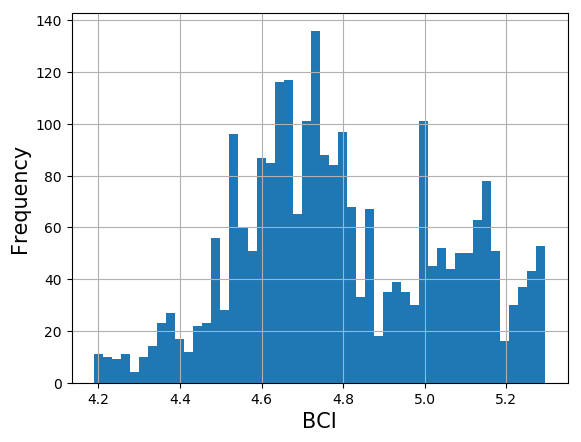

In [5]:
# Histograms of training set before z-score normalization:
X_train.BCI.hist(bins = 50)
plt.xlabel("BCI",fontsize=15)
plt.ylabel("Frequency",fontsize=15)
plt.show()
# X_train.BCI.plot(x="Date", y="BCI")


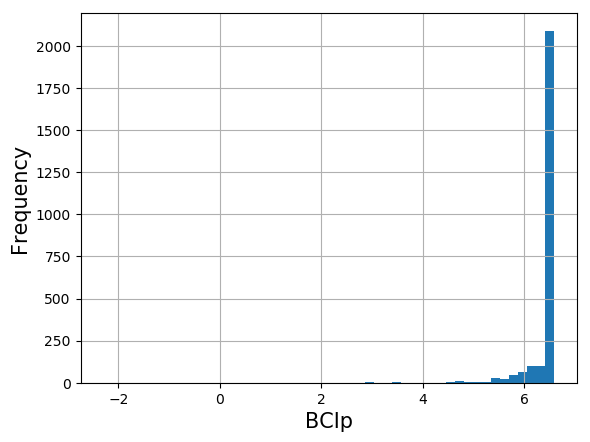

In [6]:
X_train.BCIp.hist(bins = 50)
plt.xlabel("BCIp",fontsize=15)
plt.ylabel("Frequency",fontsize=15)
plt.show()
# X_train.BCIp.plot(x="Date", y="BCIp")


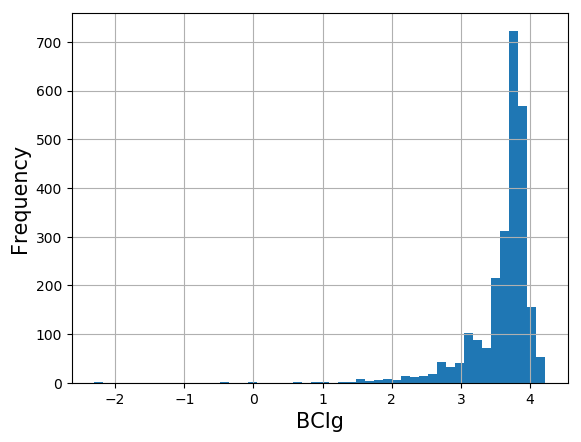

In [7]:
X_train.BCIg.hist(bins = 50)
plt.xlabel("BCIg",fontsize=15)
plt.ylabel("Frequency",fontsize=15)
plt.show()
# X_train.BCIg.plot(x="Date", y="BCIg")


In [8]:
# Standardization/z-score normalization/scaling for training set:
X_train = X_train.copy()

z_score_scaler_bci = StandardScaler()
z_score_scaler_bci.fit(X_train['BCI'].values.reshape(-1,1))
X_train['BCI'] = z_score_scaler_bci.transform(X_train['BCI'].values.reshape(-1,1))

z_score_scaler_bcip = StandardScaler()
z_score_scaler_bcip.fit(X_train['BCIp'].values.reshape(-1,1))
X_train['BCIp'] = z_score_scaler_bcip.transform(X_train['BCIp'].values.reshape(-1,1))

z_score_scaler_bcig = StandardScaler()
z_score_scaler_bcig.fit(X_train['BCIg'].values.reshape(-1,1))
X_train['BCIg'] = z_score_scaler_bcig.transform(X_train['BCIg'].values.reshape(-1,1))


In [9]:
z_score_scaler_bci.mean_, z_score_scaler_bcip.mean_, z_score_scaler_bcig.mean_


(array([ 4.8]), array([ 6.44]), array([ 3.61]))

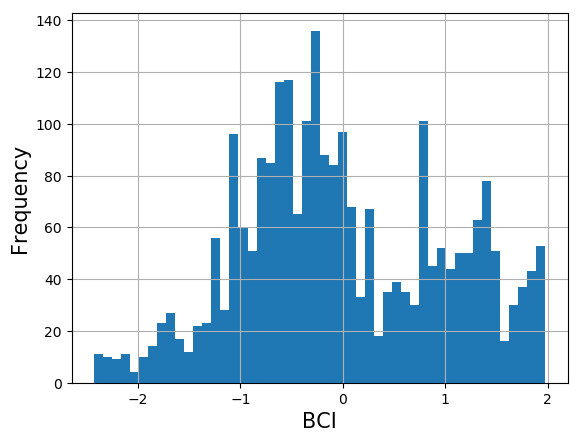

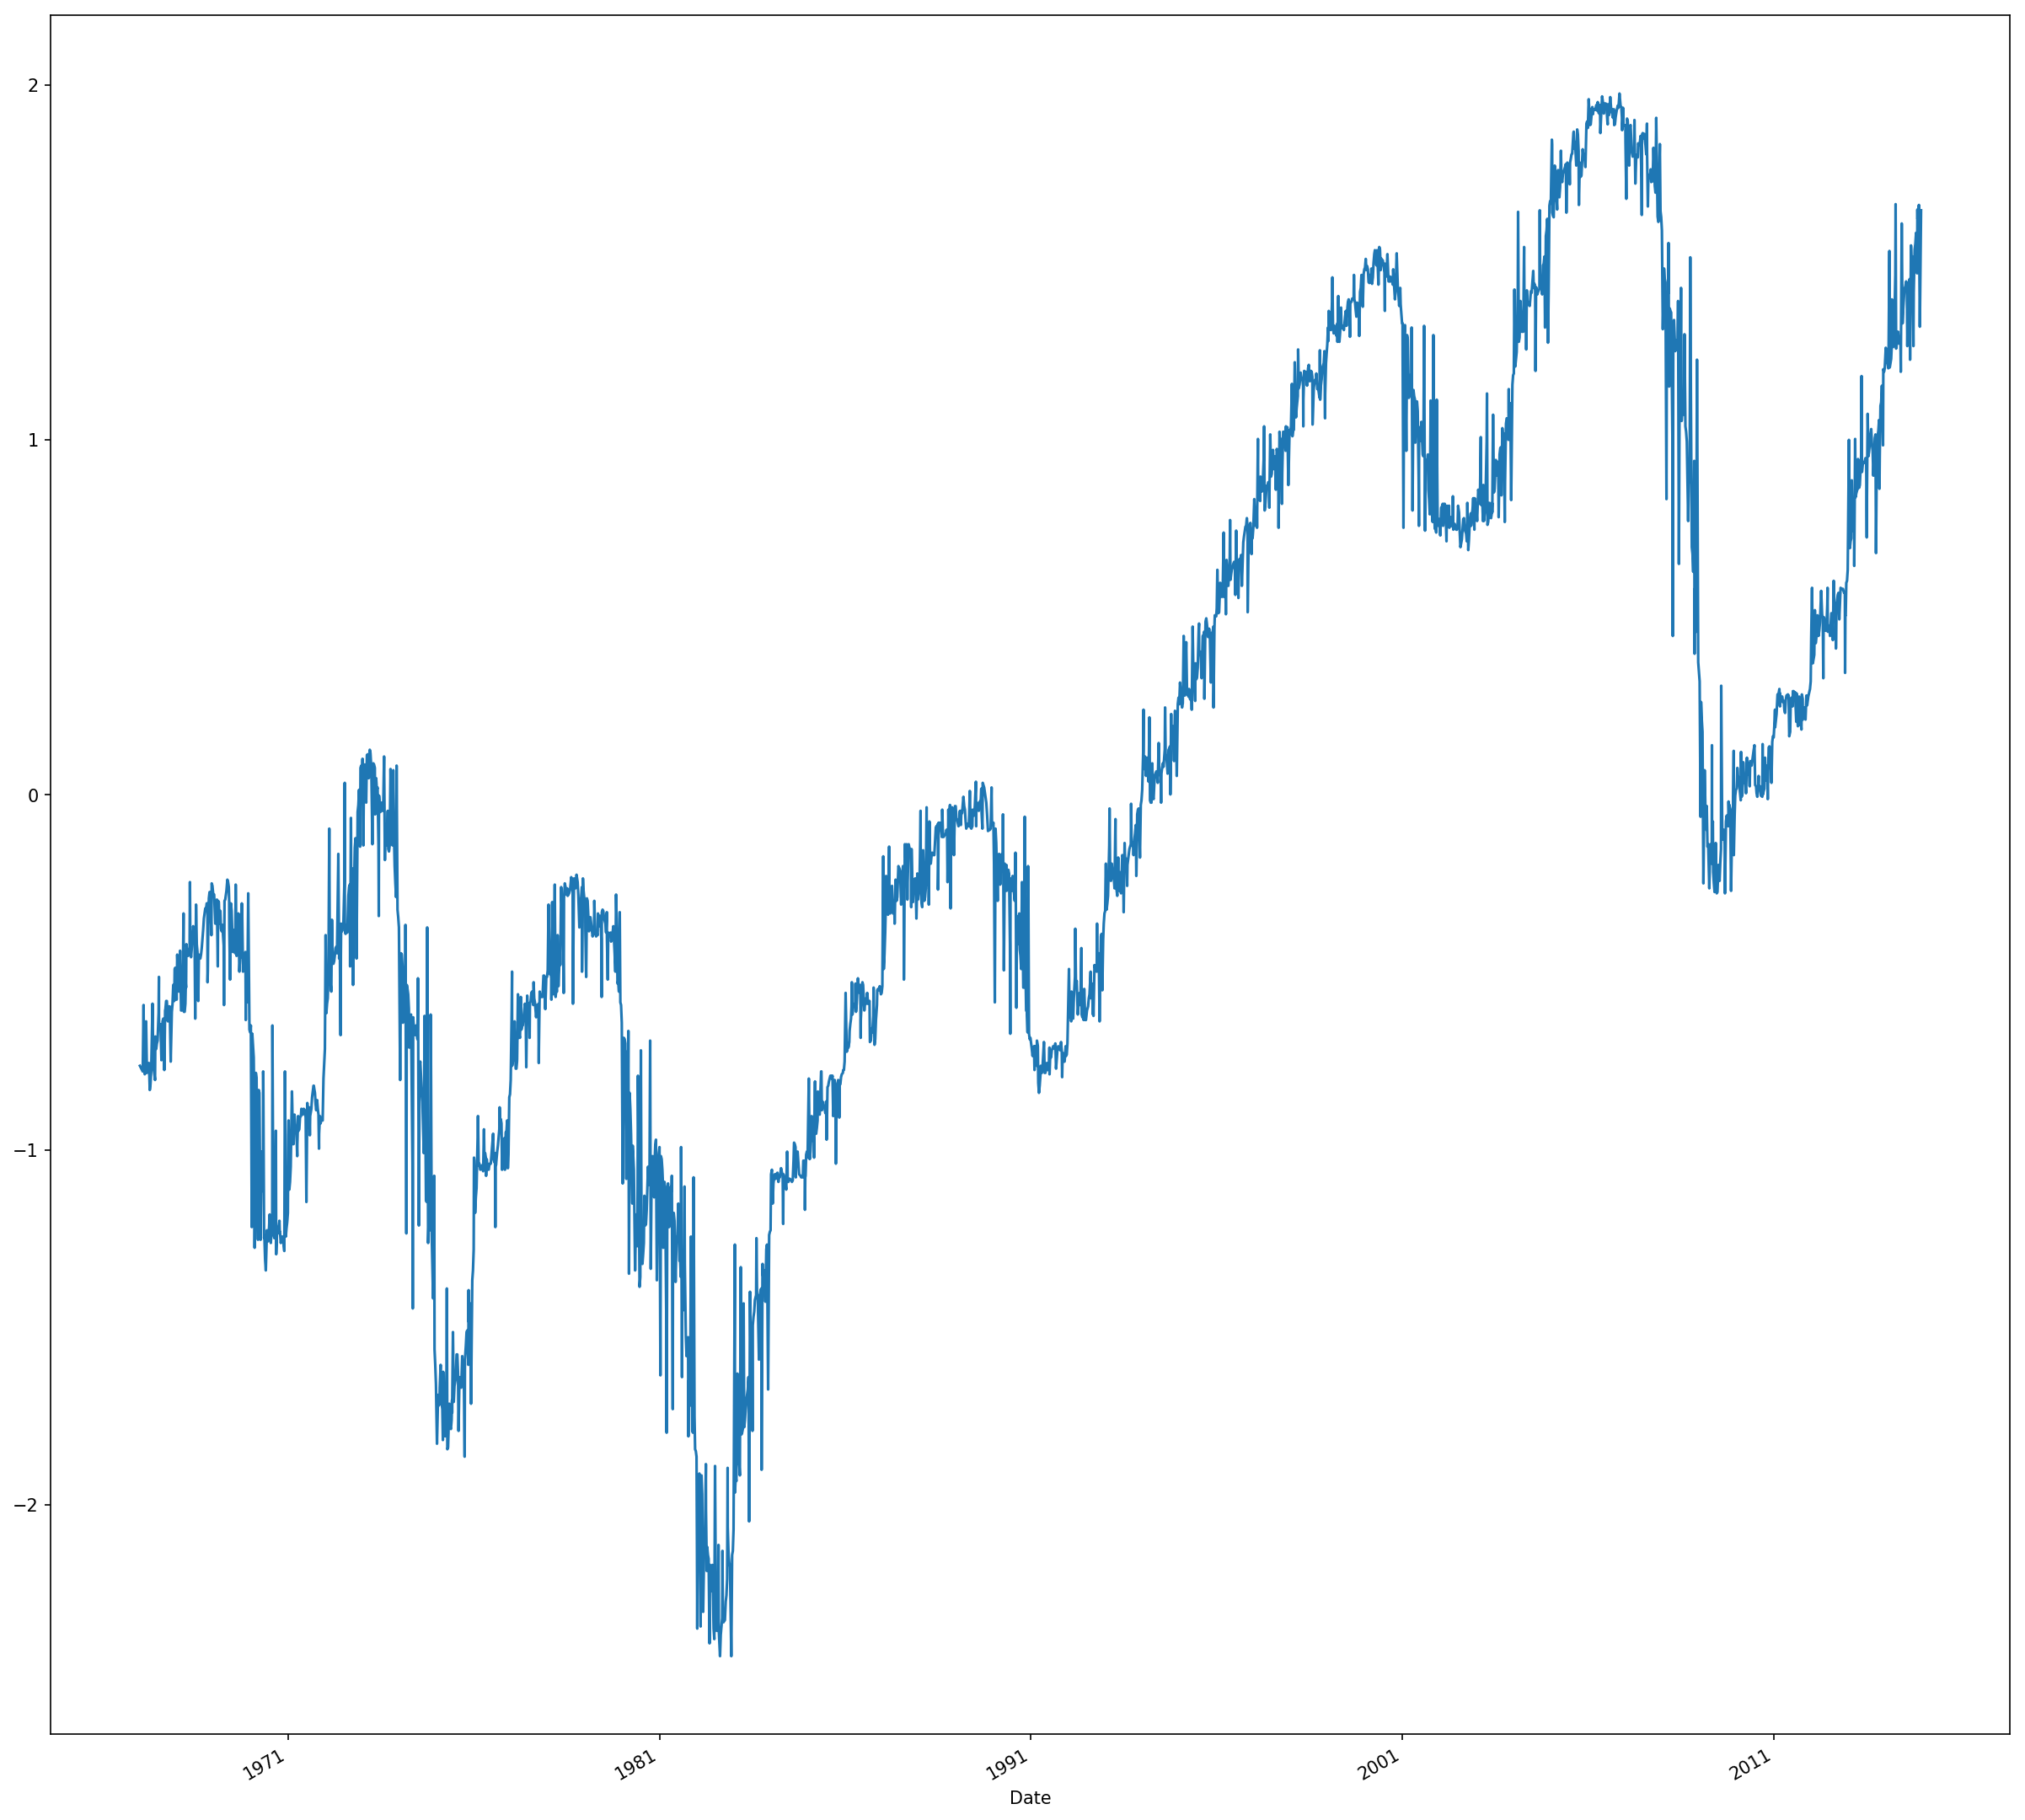

In [10]:
# Histograms of training set after z-score normalization:
X_train.BCI.hist(bins = 50)
plt.xlabel("BCI",fontsize=15)
plt.ylabel("Frequency",fontsize=15)
plt.show()
plt.figure(figsize=(20, 20), dpi=150)
X_train.BCI.plot(x="Date", y="BCI")


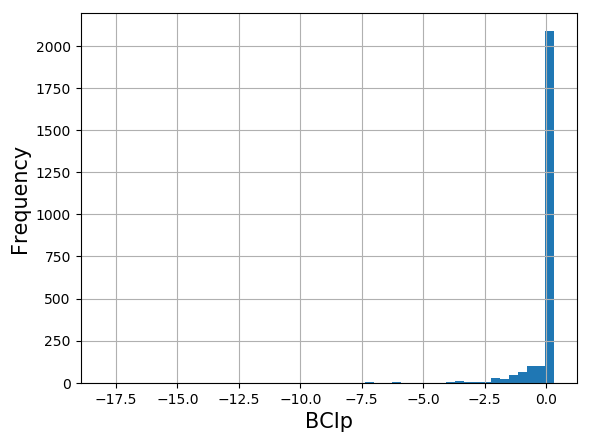

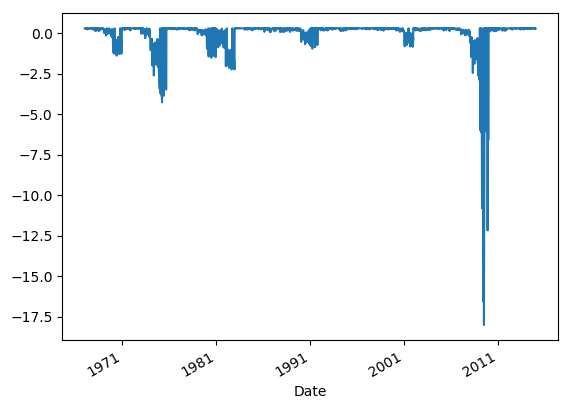

In [11]:
X_train.BCIp.hist(bins = 50)
plt.xlabel("BCIp",fontsize=15)
plt.ylabel("Frequency",fontsize=15)
plt.show()
X_train.BCIp.plot(x="Date", y="BCIp")


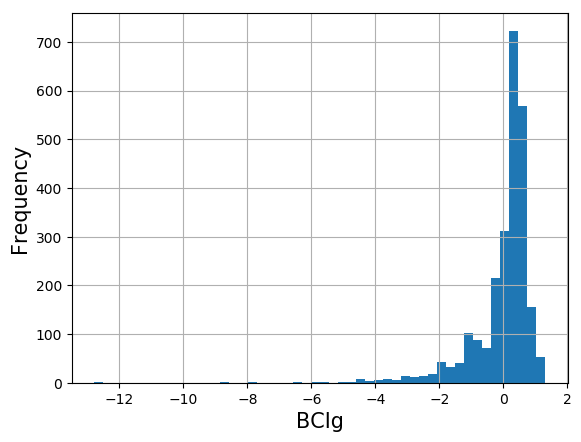

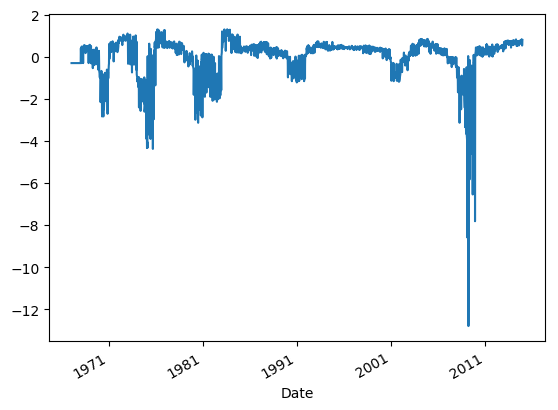

In [12]:
X_train.BCIg.hist(bins = 50)
plt.xlabel("BCIg",fontsize=15)
plt.ylabel("Frequency",fontsize=15)
plt.show()
X_train.BCIg.plot(x="Date", y="BCIg")


In [13]:
# Standardization/z-score normalization/scaling for test set (using the same scaler as for 
# training set to get them into the same scale):
X_test = X_test.copy()
X_test['BCI'] = z_score_scaler_bci.transform(X_test['BCI'].values.reshape(-1,1))

X_test['BCIp'] = z_score_scaler_bcip.transform(X_test['BCIp'].values.reshape(-1,1))

X_test['BCIg'] = z_score_scaler_bcig.transform(X_test['BCIg'].values.reshape(-1,1))

# Do a time series cross-validation on the test set by splitting it to k folds and doing a "rolling"
# validation against a validation fold, then averaging out the metrics.
splits = 4 # This is the number of splits/folds in the rolling validation.
tscv = TimeSeriesSplit(n_splits=splits)
LogC_AUC_ROC = 0
SVM_AUC_ROC = 0
RF_AUC_ROC = 0
LogC_acc = 0
SVM_acc = 0
RF_acc = 0
for train_index, test_index in tscv.split(X_train): # Rolling cross-validation happens inside this loop.
    print("TRAIN:", train_index, "TEST:", test_index)
    X_train_fold, X_validation_fold = X_train.iloc[train_index[:-lag_of_y], X_train.columns != "USRECD"], \
        X_train.iloc[test_index[:-lag_of_y], X_train.columns != "USRECD"]
    y_train_fold, y_validation_fold = y_train.iloc[train_index[lag_of_y:], y_train.columns == "USRECD"], \
        y_train.iloc[test_index[lag_of_y:], y_train.columns == "USRECD"]


TRAIN: [  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29 ..., 472 473 474 475 476
 477 478 479 480 481 482 483 484 485 486 487 488 489 490 491 492 493 494
 495 496 497 498 499 500 501] TEST: [ 502  503  504  505  506  507  508  509  510  511  512  513  514  515  516
  517  518  519  520  521  522  523  524  525  526  527  528  529  530  531
 ...,  971  972  973  974  975  976  977  978  979  980  981  982  983  984
  985  986  987  988  989  990  991  992  993  994  995  996  997  998  999
 1000]
TRAIN: [   0    1    2    3    4    5    6    7    8    9   10   11   12   13   14
   15   16   17   18   19   20   21   22   23   24   25   26   27   28   29
 ...,  971  972  973  974  975  976  977  978  979  980  981  982  983  984
  985  986  987  988  989  990  991  992  993  994  995  996  997  998  999
 1000] TEST: [1001 1002 1003 1004 1005 1006 1007 1008 1009 1010 1011 1012 1013 1014 1015
 1016 1017 1018 1019 1020 

In [14]:
    lr = linear_model.LogisticRegression()
    lr.fit(X_train_fold, y_train_fold["USRECD"])
    # plt.plot(y_validation_fold.reset_index().Date, lr.predict(X_validation_fold))
    positive_probs = [p[1] for p in lr.predict_proba(X_validation_fold)]
    AUC_ROC = metrics.roc_auc_score(y_validation_fold, positive_probs)
    LogC_AUC_ROC += AUC_ROC
    predictions = lr.predict(X_validation_fold)
    Acc = accuracy_score(y_validation_fold, predictions)
    LogC_acc += Acc
    print("Logistic regression AUC ROC: ", AUC_ROC)
    print("Logistic regression accuracy: ", Acc)

Logistic regression AUC ROC:  0.876826923077
Logistic regression accuracy:  0.813807531381


In [15]:
    sv = svm.SVC(kernel='linear', class_weight='balanced', probability=True)
    sv.fit(X_train_fold, y_train_fold["USRECD"])
    # plt.plot(y_validation_fold.reset_index().Date, sv.predict(X_validation_fold))
    positive_probs = [p[1] for p in sv.predict_proba(X_validation_fold)]
    AUC_ROC = metrics.roc_auc_score(y_validation_fold, positive_probs)
    SVM_AUC_ROC += AUC_ROC
    predictions = sv.predict(X_validation_fold)
    Acc = accuracy_score(y_validation_fold, predictions)
    SVM_acc += Acc
    print("Penalized SVM AUC ROC: ", AUC_ROC)
    print("Penalized SVM accuracy: ", Acc)

Penalized SVM AUC ROC:  0.871314102564
Penalized SVM accuracy:  0.826359832636


Random forest AUC ROC:  0.745224358974
Random forest accuracy:  0.765690376569


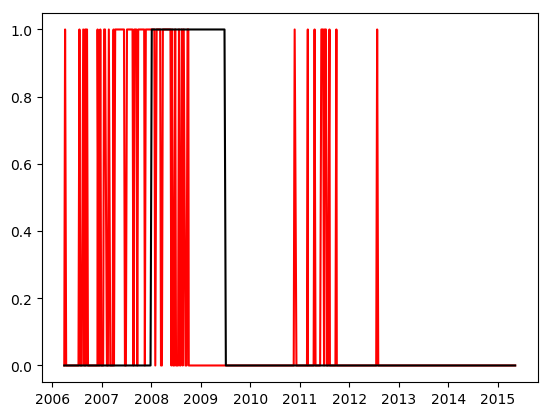

In [16]:
    rf = RandomForestClassifier()
    rf.fit(X_train_fold, y_train_fold["USRECD"])
    plt.plot(y_validation_fold.reset_index().Date, rf.predict(X_validation_fold), c="red")
    positive_probs = [p[1] for p in rf.predict_proba(X_validation_fold)]
    AUC_ROC = metrics.roc_auc_score(y_validation_fold, positive_probs)
    RF_AUC_ROC += AUC_ROC
    predictions = rf.predict(X_validation_fold)
    Acc = accuracy_score(y_validation_fold, predictions)
    RF_acc += Acc
    print("Random forest AUC ROC: ", AUC_ROC)
    print("Random forest accuracy: ", Acc)
    plt.plot(y_validation_fold.reset_index().Date, y_validation_fold["USRECD"], c="black")


In [17]:
print()
print("LogC ROC AUC average: ", LogC_AUC_ROC/splits)
print("LogC acc average: ", LogC_acc/splits)
print("SVM ROC AUC average: ", SVM_AUC_ROC/splits)
print("SVM acc average: ", SVM_acc/splits)
print("RF ROC AUC average: ", RF_AUC_ROC/splits)
print("RF acc average: ", RF_acc/splits)


LogC ROC AUC average:  0.219206730769
LogC acc average:  0.203451882845
SVM ROC AUC average:  0.217828525641
SVM acc average:  0.206589958159
RF ROC AUC average:  0.186306089744
RF acc average:  0.191422594142
